# Code to plot the final fitted CEF Hamiltonians for $\rm KErSe_2$ and $\rm CsErSe_2$

Allen Scheie

December, 2019

### The Hamiltonians were fit using KES_CEF_fitPC.ipynb, KES_CEF_fit2.ipynb,  CES_CEF_fitPC.ipynb, and CES_CEF_fit2.ipynb.
### The uncertanties were generated with KES_CEF_loopthrough.ipynb and CES_CEF_loopthrough.ipynb

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import Normalize
from matplotlib import cm
# from matplotlib.patches import Rectangle
import sys

import plotformat as pf
import PyCrystalField as cef
from pythonlib.MsliceData import mslice

In [2]:
data1p6K = np.genfromtxt('KES_CEF_data/cuts_ei9mev_1p6K.txt', unpack=True)
data15K = np.genfromtxt('KES_CEF_data/cuts_ei9mev_15K.txt', unpack=True)
data100K = np.genfromtxt('KES_CEF_data/cuts_ei9mev_100K.txt', unpack=True)

KESalldata = [data1p6K,data15K,data100K]
KESdatatemps = [1.8, 15, 100]

## Scale
for KES in KESalldata:
    KES[1] *= 1e3
    KES[2] *= 1e3

In [3]:
datadirectory = 'CES_CEF_data/'

cutlist =   ['CES_100K_9meV',            'CES_2K_9meV',
            'CES_50K_9meV',            'CES_2K_9meV_3T',
            'CES_2K_9meV_5T',            'CES_2K_9meV_0T',
            'CES_2K_9meV_1T',            'CES_2K_9meV_2T',
            'CES_2K_9meV_0Tb',    'CES_2K_30meV']

ProtonCharges = [7.97, 8*3, 8*3+5.61, 8+6.59, 5.07, 2, 4,4,1.13, 8*4+5.1]  
# The proton charge doesn't seem to correct the normalization problem.
# Rather, the sample seems to have decreased in intensity post-5T field...
# See the cell below where I derive the scale factor.
scalefactor = 1.66582869
Norm = [scalefactor, 1,1, scalefactor, scalefactor, scalefactor, 
        scalefactor, scalefactor, scalefactor, scalefactor,]

DATA = {}
for i,cn in enumerate(cutlist):
    DATA[cn] = mslice(datadirectory+cn)
    DATA[cn].normalize(1e3*Norm[i])
    
    
## Define data

CESalldata = [DATA[cn] for cn in ['CES_2K_9meV', 'CES_50K_9meV']]
CESdatatemps = [1.8, 50]

<IPython.core.display.Javascript object>


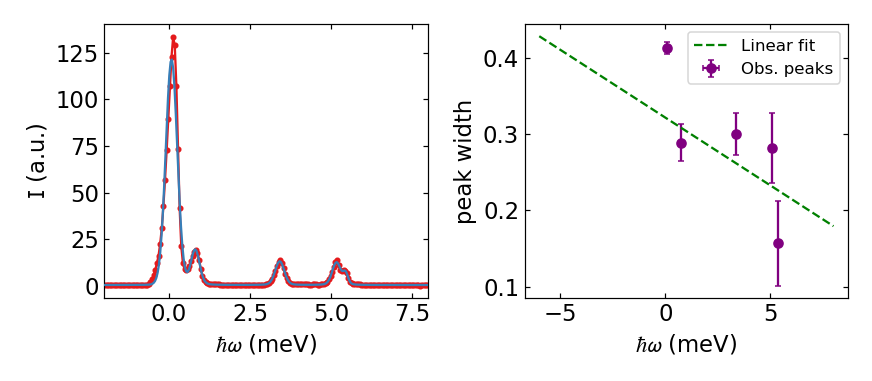

[0.07517211974600753, 0.7310563754703909, 3.3430389113350087, 5.0971456786049085, 5.377777212698675] [0.4132660062508849, 0.288638322840261, 0.3005368004446522, 0.2815966433551471, 0.1566254770893106] 0.050394384987051934
[-0.01778629  0.32154258]
[[0.075, 0.003], [0.731, 0.008], [3.343, 0.01], [5.097, 0.021], [5.378, 0.027]]


In [4]:
## Pick out observed eigenvalues
from scipy.special import wofz

def gaus(x, a, x0, sig):
    return a/(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - x0)/sig, 2.)/2.)

def voigt(x, a, x0, alpha, gamma):
    """ Return the Voigt line shape at x with Lorentzian component FWHM gamma
    and Gaussian component FWHM alpha."""
    sigma = (0.5*alpha) / np.sqrt(2 * np.log(2))
    return a*np.real(wofz(((x-x0) + 1j*(0.5*gamma))/sigma/np.sqrt(2))) / sigma\
                                                        /np.sqrt(2*np.pi)

dx, dy, de = CESalldata[0].cx, CESalldata[0].ci, CESalldata[0].ce

def gausfitfun(x, a0,x0,w0, a1,x1,w1, a2,x2,w2, a3,x3,w3, a4,x4,w4):
    return gaus(x-x0, a0,0,w0) + gaus(x-x0, a1,x1,w1) + gaus(x-x0, a2,x2,w2) +\
            gaus(x-x0, a3,x3,w3) + gaus(x-x0, a4,x4,w4) + 0.45

LW = 0.1
def voigtfitfun(x, a0,x0,w0, a1,x1,w1, a2,x2,w2, a3,x3,w3, a4,x4,w4, lw0, lw):
    return voigt(x-x0, a0,0,w0, lw0) + voigt(x-x0, a1,x1,w1, lw) + voigt(x-x0, a2,x2,w2, lw) +\
            voigt(x-x0, a3,x3,w3, lw) + voigt(x-x0, a4,x4,w4, lw) + 0.45

p0 = [56, 0.15,0.27, 8,0.67,0.25, 5,3.27,0.25, 3,5.0,0.10, 2,5.25,0.10, 0.1, 0.1]

CESpoptinitial, CESpcovinitial = curve_fit(voigtfitfun, dx, dy, sigma=de, p0=p0)
CESuncinitial = np.sqrt(np.diag(CESpcovinitial))

f, ax = plt.subplots(1,2, figsize=(8,3.5))

ax[0].errorbar(dx,dy,de, marker='.')
xxx = np.linspace(-2,10,300)
# ax[0].plot(xxx, voigtfitfun(xxx, *p0), zorder=10)
ax[0].plot(xxx, voigtfitfun(xxx, *CESpoptinitial), zorder=10)
ax[0].set_xlim(-2,8)
ax[0].set_xlabel('$\\hbar \\omega$ (meV)')
ax[0].set_ylabel('$\\rm I$ (a.u.)')

#### 
CESObsEnergies, CESDOE = [CESpoptinitial[3*i+1] for i in range(0,5)],  [CESuncinitial[3*i+1] for i in range(0,5)], 
CESObsWidths, CESDOW = [CESpoptinitial[3*i+2] for i in range(0,5)],    [CESuncinitial[3*i+2] for i in range(0,5)]

## Adjust the measured observed width so it matches the peak (not perfectly Gaussian...)
print(CESObsEnergies, CESObsWidths, CESpoptinitial[-1])
CESfittedLW = CESpoptinitial[-1]

ax[1].errorbar(CESObsEnergies, CESObsWidths, xerr = CESDOE, yerr = CESDOW, capsize=2, marker='o', 
               ls='none', color='purple', label='Obs. peaks')
def straightline(x,a,b):
    return a*x + b
CESwidth_popt, CESwidth_pcov = curve_fit(straightline, CESObsEnergies[1:], CESObsWidths[1:],  p0=[-0.008,0.16])
xxx = np.linspace(-6,8,3)
ax[1].plot(xxx, straightline(xxx, *CESwidth_popt), color='green', ls='--', label='Linear fit')
# ax[1].plot(xxx, resfunc(xxx), color='red', ls='--', label = "Ovi's res. func.")
ax[1].set_xlabel("$\\hbar \\omega$ (meV)")
ax[1].set_ylabel("peak width")
ax[1].legend(fontsize=11)

plt.tight_layout()

print(CESwidth_popt)

## Print energies and uncertainties
print([[np.around(CESObsEnergies[i],3), np.around(CESDOE[i],3)] for i in range(len(CESObsEnergies))])

<IPython.core.display.Javascript object>


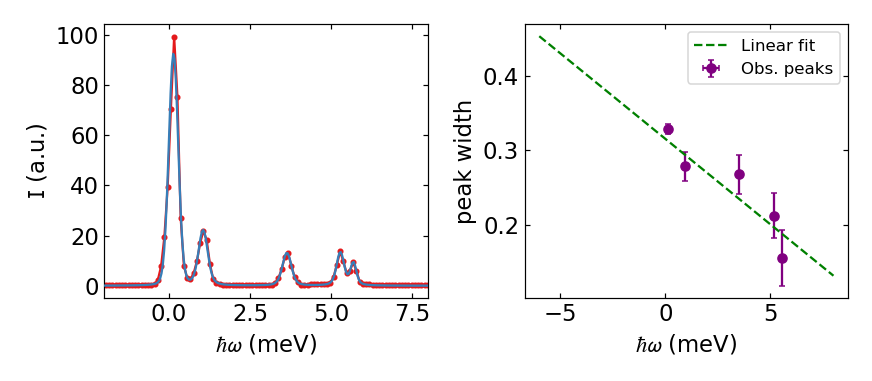

[0.13633949843797963, 0.9151049673286019, 3.503668196065069, 5.154484613019778, 5.558456624151638] [0.32811681324370234, 0.27859846712745556, 0.2676185267329996, 0.21253189410730797, 0.15574420407721323] 0.10714756555397817
[-0.02292122  0.31533263]
[[0.136, 0.003], [0.915, 0.006], [3.504, 0.009], [5.154, 0.011], [5.558, 0.013]]


In [5]:
dx, dy, de = KESalldata[0][0], KESalldata[0][1], KESalldata[0][2]

def gausfitfun(x, a0,x0,w0, a1,x1,w1, a2,x2,w2, a3,x3,w3, a4,x4,w4):
    return gaus(x-x0, a0,0,w0) + gaus(x-x0, a1,x1,w1) + gaus(x-x0, a2,x2,w2) +\
            gaus(x-x0, a3,x3,w3) + gaus(x-x0, a4,x4,w4) + 0.00015

LW = 0.1
def voigtfitfun(x, a0,x0,w0, a1,x1,w1, a2,x2,w2, a3,x3,w3, a4,x4,w4, lw0, lw):
    return voigt(x-x0, a0,0,w0, lw0) + voigt(x-x0, a1,x1,w1, lw) + voigt(x-x0, a2,x2,w2, lw) +\
            voigt(x-x0, a3,x3,w3, lw) + voigt(x-x0, a4,x4,w4, lw) + 0.00015

p0 = [4e-2, 0.15,0.25, 9e-3,0.87,0.25, 5e-3,3.47,0.25, 5e-3,5.11,0.18, 4e-3,5.58,0.18, 0.1, 0.1]

KESpoptinitial, KESpcovinitial = curve_fit(voigtfitfun, dx, dy, sigma=de, p0=p0)
KESuncinitial = np.sqrt(np.diag(KESpcovinitial))

f, ax = plt.subplots(1,2, figsize=(8,3.5))

ax[0].errorbar(dx,dy,de, marker='.')
xxx = np.linspace(-2,10,300)
# ax[0].plot(xxx, voigtfitfun(xxx, *p0), zorder=10)
ax[0].plot(xxx, voigtfitfun(xxx, *KESpoptinitial), zorder=10)
ax[0].set_xlim(-2,8)
ax[0].set_xlabel('$\\hbar \\omega$ (meV)')
ax[0].set_ylabel('$\\rm I$ (a.u.)')

#### 
KESObsEnergies, KESDOE = [KESpoptinitial[3*i+1] for i in range(0,5)],  [KESuncinitial[3*i+1] for i in range(0,5)], 
KESObsWidths, KESDOW = [KESpoptinitial[3*i+2] for i in range(0,5)],    [KESuncinitial[3*i+2] for i in range(0,5)]
print(KESObsEnergies, KESObsWidths, KESpoptinitial[-1])
KESfittedLW = KESpoptinitial[-1]

ax[1].errorbar(KESObsEnergies, KESObsWidths, xerr = KESDOE, yerr = KESDOW, capsize=2, marker='o', 
               ls='none', color='purple', label='Obs. peaks')
def straightline(x,a,b):
    return a*x + b
# width_popt, width_pcov = curve_fit(straightline, ObsEnergies, ObsWidths, sigma=DOW, p0=[-0.008,0.16])
KESwidth_popt, KESwidth_pcov = curve_fit(straightline, KESObsEnergies[1:], KESObsWidths[1:],  p0=[-0.008,0.16])
xxx = np.linspace(-6,8,3)
ax[1].plot(xxx, straightline(xxx, *KESwidth_popt), color='green', ls='--', label='Linear fit')
ax[1].set_xlabel("$\\hbar \\omega$ (meV)")
ax[1].set_ylabel("peak width")
ax[1].legend(fontsize=11)

plt.tight_layout()

print(KESwidth_popt)

## Print energies and uncertainties
print([[np.around(KESObsEnergies[i],3), np.around(KESDOE[i],3)] for i in range(len(KESObsEnergies))])

# Plot fitted data ranges

<IPython.core.display.Javascript object>


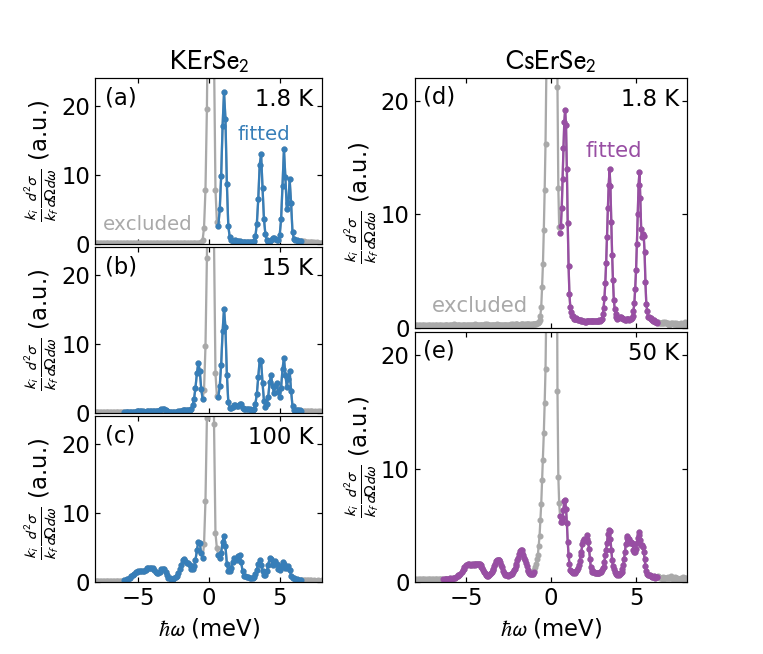

In [6]:
## Black out the elastic line, because it includes extra contributions from incoherent scattering, background, etc.
from copy import deepcopy

########################### KES

KESfitdata = deepcopy(KESalldata)

# fitdata[0][:,:100] *= np.nan
for i in range(len(KESfitdata)):
    KESfitdata[i] = np.hstack((KESfitdata[i][:,40:96], KESfitdata[i][:,106:-15]))
KESfitdata[0] = KESfitdata[0][:,56:]

########################### CES

CESfitdata = deepcopy(CESalldata)

# fitdata[0][:,:100] *= np.nan
for i in range(len(CESfitdata)):
    CESfitdata[i].cx = np.hstack((CESfitdata[i].cx[20:120], CESfitdata[i].cx[150:265]))
    CESfitdata[i].ci = np.hstack((CESfitdata[i].ci[20:120], CESfitdata[i].ci[150:265]))
    CESfitdata[i].ce = np.hstack((CESfitdata[i].ce[20:120], CESfitdata[i].ce[150:265]))
    
CESfitdata[0].cx = CESfitdata[0].cx[100:]
CESfitdata[0].ci = CESfitdata[0].ci[100:]
CESfitdata[0].ce = CESfitdata[0].ce[100:]
    
    
    
######################################################3

fig1 = plt.figure(figsize=(7,6))
outer = gridspec.GridSpec(1,2, figure=fig1, width_ratios=[1,1.2], wspace=0.37)
gs0 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=outer[0], hspace=0.02)
gs1 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[1], hspace=0.02)

ax1 = [fig1.add_subplot(gs0[i]) for i in range(3)]
ax2 = [fig1.add_subplot(gs1[i]) for i in range(2)]
plt.setp(ax1[0].get_xticklabels(), visible=False)
plt.setp(ax1[1].get_xticklabels(), visible=False)
plt.setp(ax2[0].get_xticklabels(), visible=False)

############# KES
KEScolor = pf.cpal1[1]
exccolor= 'darkgrey'

for i,data in enumerate(KESfitdata):
    ax1[i].errorbar(KESalldata[i][0], KESalldata[i][1], KESalldata[i][2], marker='.',
                   color=exccolor, label='excluded')
    ax1[i].text(0.96,0.94, str(KESdatatemps[i])+' K', transform=ax1[i].transAxes,
              verticalalignment='top', horizontalalignment='right')
    ul = 56
    ax1[i].errorbar(data[0][:ul], data[1][:ul], data[2][:ul], marker='.', color = KEScolor, label='fitted')
    ax1[i].errorbar(data[0][ul:], data[1][ul:], data[2][ul:], marker='.', color = KEScolor)
    ax1[i].set_ylim(0,24)
    ax1[i].set_xlim(-8,8)

ax1[-1].set_xlabel('$\\hbar \\omega$ (meV)')
# ax1[0].legend()
ax1[0].text(2,15,'fitted', color=KEScolor, fontsize=13)
ax1[0].text(-7.5,2,'excluded', color=exccolor, fontsize=13)

############# CES
CEScolor = pf.cpal1[3]

for i,data in enumerate(CESfitdata):
    ax2[i].errorbar(CESalldata[i].cx, CESalldata[i].ci, CESalldata[i].ce, marker='.', 
                    color=exccolor, label='excluded')
    ax2[i].text(0.97,0.96, str(CESdatatemps[i])+' K', transform=ax2[i].transAxes,
              verticalalignment='top', horizontalalignment='right')
    ax2[i].set_ylim(0,22)
    ax2[i].set_xlim(-8,8)
    

ul = 1
ax2[0].errorbar(CESfitdata[0].cx[:ul], CESfitdata[0].ci[:ul], CESfitdata[0].ce[:ul], marker='.', color = CEScolor)
ax2[0].errorbar(CESfitdata[0].cx[ul:], CESfitdata[0].ci[ul:], CESfitdata[0].ce[ul:], marker='.', color = CEScolor,
               label='fitted')
ul = 100
ax2[1].errorbar(CESfitdata[1].cx[:ul], CESfitdata[1].ci[:ul], CESfitdata[1].ce[:ul], marker='.', color = CEScolor)
ax2[1].errorbar(CESfitdata[1].cx[ul:], CESfitdata[1].ci[ul:], CESfitdata[1].ce[ul:], marker='.', color = CEScolor, 
                label='fitted')
ax2[-1].set_xlabel('$\\hbar \\omega$ (meV)')
# ax2[0].set_ylabel('$\\rm I$ (a.u.)')
ax2[0].text(2,15,'fitted', color=CEScolor, fontsize=14)
ax2[0].text(-7,1.4,'excluded', color=exccolor, fontsize=14)

subplotlabels = 'abcdefg'
for i, axes in enumerate(np.hstack((ax1, ax2))):
    if i < 3:
        axes.text(0.04,0.95,'('+subplotlabels[i]+')',horizontalalignment='left',
                verticalalignment='top',transform=axes.transAxes, color='k')
    else:
        axes.text(0.03,0.97,'('+subplotlabels[i]+')',horizontalalignment='left',
                verticalalignment='top',transform=axes.transAxes, color='k')
    axes.set_ylabel('$\\frac{k_i}{k_f} \\frac{d^2 \sigma}{d \\Omega d \\omega}$ (a.u.)', labelpad=0)
    axes.set_yticks(np.arange(0,25,10))

    
ax1[0].set_title('$\\rm KErSe_2$')
ax2[0].set_title('$\\rm CsErSe_2$')
    
plt.tight_layout()
pf.replace_zeros()

# Define best fit parameters

In [7]:
ion = 'Er3+'
ionJ = cef.Jion[ion][2]

Er_O = []
for n in range(2,8,2):
    for m in range(0,n+1,3):
        if   n == 6: i = 8 + m
        elif n == 4: i = 3 + m
        elif n == 2: i = m
        Er_O.append(  cef.StevensOp(ionJ,n,m)  )
        
######################################################

KESFitCoefRes1a, KESFitCoefRes2a = np.load('KES_bestfitcoeff.npy',allow_pickle=True)

KESFCR = [KESFitCoefRes1a, KESFitCoefRes2a]


KESErCoefFit1a = cef.CFLevels(Er_O, KESFitCoefRes1a['coeff'])
KESErCoefFit1a.diagonalize()
KESErCoefFit2a = cef.CFLevels(Er_O, KESFitCoefRes2a['coeff'])
KESErCoefFit2a.diagonalize()

#####################################################

CESFitCoefRes1b, CESFitCoefRes2b = np.load('CES_bestfitcoeff.npy',allow_pickle=True)

CESFCR = [CESFitCoefRes1b, CESFitCoefRes2b]

CESErCoefFit1 = cef.CFLevels(Er_O, CESFitCoefRes1b['coeff'])
CESErCoefFit1.diagonalize()
CESErCoefFit2 = cef.CFLevels(Er_O, CESFitCoefRes2b['coeff'])
CESErCoefFit2.diagonalize()


def bkg(iii, x):
    if iii == 0:
        return gaus(x, 2, 3.5, 2.5) + 0.2  + gaus(x, 7, 0.1, 0.25)
    else:
        return gaus(x, 6.5, 1.5, 5) + 0.1  + gaus(x, 7, 0.1, 0.25)
    
# KESErCoefFit1a.printEigenvectors()
# KESErCoefFit2a.printEigenvectors()
print(KESFitCoefRes1a['coeff'])
print(KESFitCoefRes2a['coeff'])

[-2.76006429e-02 -3.98885263e-04 -1.41582191e-02  3.15134583e-06
 -7.68744759e-06  3.26836317e-05]
[ 2.47378884e-02 -4.78169984e-04  1.27514677e-02  1.05507246e-06
  4.57575724e-05  2.19821260e-05]


# Print G tensor

The $g$ tensor is calculated by converting the Hamiltonian to the LS basis

In [8]:
ion = 'Er3+'
JtoLSThet = np.array([cef.LSThet[ion][nn]/cef.Thet[ion][nn] for nn in [0,1,1,2,2,2]])
# print(JtoLSThet)

Er_O_LS = []
for n in range(2,8,2):
    for m in range(0,n+1,3):
        Er_O_LS.append(  cef.LS_StevensOp(cef.Jion[ion][1], cef.Jion[ion][0],n,m)  )

LS_KES = cef.LS_CFLevels(Er_O_LS, KESFitCoefRes1a['coeff']*JtoLSThet, 
                                 cef.Jion[ion][1], cef.Jion[ion][0], -1e5)
LS_KES.diagonalize()

L, S = cef.Jion[ion][1], cef.Jion[ion][0]
Sx = cef.LSOperator.Sx(L, S)
Sy = cef.LSOperator.Sy(L, S)
Sz = cef.LSOperator.Sz(L, S)
Lx = cef.LSOperator.Lx(L, S)
Ly = cef.LSOperator.Ly(L, S)
Lz = cef.LSOperator.Lz(L, S)


#######
GSK1, GSK2 = LS_KES.eigenvectors[0], LS_KES.eigenvectors[1]
print(2*np.dot(GSK1,np.dot(Lz.O+2*Sz.O, GSK1)))
print(2*np.dot(GSK1,np.dot(Lx.O+2*Sx.O, GSK2)))
print(np.dot(GSK1,np.dot(Lx.O+2*Sx.O + (Ly.O+2*Sy.O)*1j, GSK2)))

np.real(LS_KES.gtensor())

(4.564468390012832+0j)
(-5.603226588500307+0j)
(-6.38947354895784+0j)


array([[ 1.20046495e+00,  0.00000000e+00, -1.66533454e-16],
       [ 0.00000000e+00,  1.20046495e+00,  0.00000000e+00],
       [-2.49800181e-16,  0.00000000e+00,  1.20046467e+00]])

In [9]:
def printLaTexCEFparams(B1, B2):
#     precisions = [4,6,4,8,8,7]
    '''prints CEF parameters in the output that Latex can read'''
    print('\\begin{table}\n\\caption{Fitted CEF parameters for $\\rm{KErSe_2}$}')
    print('\\begin{ruledtabular}')
    print('\\begin{tabular}{c|'+'c'*2+'}')
    # Create header
    print('$B_n^m$ (meV) &'+'Model 1 & Model 2'
        +' \\tabularnewline\n \\hline ')
    for i, (n,m) in enumerate([[n,m] for n in range(2,8,2) for m in range(0,n+1,3)]):
#         precision=precisions[i]
#         print('$ B_'+str(n)+'^'+str(m)+'$ &', np.around(B1[i],decimals=precision),'&',
#               np.around(B2[i],decimals=precision),
#               '\\tabularnewline')
        print('$ B_'+str(n)+'^'+str(m)+'$ &', stringify(B1[i]),'&', stringify(B2[i]),
              '\\tabularnewline')
    print('\\end{tabular}\\end{ruledtabular}')
    print('\\label{flo:KES_CEF_params}\n\\end{table}')
    
def stringify(num):
    strnum = '%.3E' % num
    return strnum.replace('E-0','$\\times 10^{-') + '}$'
    
printLaTexCEFparams(KESFitCoefRes1a['coeff'],KESFitCoefRes2a['coeff'])

print('\n')

printLaTexCEFparams(CESFitCoefRes1b['coeff'],CESFitCoefRes2b['coeff'])

print('\n')

printLaTexCEFparams(KESFitCoefRes1a['coeff'],CESFitCoefRes1b['coeff'])

\begin{table}
\caption{Fitted CEF parameters for $\rm{KErSe_2}$}
\begin{ruledtabular}
\begin{tabular}{c|cc}
$B_n^m$ (meV) &Model 1 & Model 2 \tabularnewline
 \hline 
$ B_2^0$ & -2.760$\times 10^{-2}$ & 2.474$\times 10^{-2}$ \tabularnewline
$ B_4^0$ & -3.989$\times 10^{-4}$ & -4.782$\times 10^{-4}$ \tabularnewline
$ B_4^3$ & -1.416$\times 10^{-2}$ & 1.275$\times 10^{-2}$ \tabularnewline
$ B_6^0$ & 3.151$\times 10^{-6}$ & 1.055$\times 10^{-6}$ \tabularnewline
$ B_6^3$ & -7.687$\times 10^{-6}$ & 4.576$\times 10^{-5}$ \tabularnewline
$ B_6^6$ & 3.268$\times 10^{-5}$ & 2.198$\times 10^{-5}$ \tabularnewline
\end{tabular}\end{ruledtabular}
\label{flo:KES_CEF_params}
\end{table}


\begin{table}
\caption{Fitted CEF parameters for $\rm{KErSe_2}$}
\begin{ruledtabular}
\begin{tabular}{c|cc}
$B_n^m$ (meV) &Model 1 & Model 2 \tabularnewline
 \hline 
$ B_2^0$ & -3.559$\times 10^{-2}$ & 3.114$\times 10^{-2}$ \tabularnewline
$ B_4^0$ & -3.849$\times 10^{-4}$ & -4.720$\times 10^{-4}$ \tabularnewline
$ B

In [10]:
### Print best fit CEF values with uncertainty
#### The uncertainty comes from the loopthrough ipynotebooks. Run them to see how these are generated

KES_bestfit_withU = [
[-0.02772780224706159, 0.0033230000329972226] ,
[-0.0003986791337847824, 5.338556061511149e-06] ,
[-0.014164750780259892, 0.00018065150057829105] ,
[3.152118222727135e-06, 1.8400023015448065e-08] ,
[-7.615963268822789e-06, 1.9372213339055308e-06] ,
[3.2752689577855864e-05, 1.9243929592010036e-06]]


CES_bestfit_withU = [
[-0.03558811064292953, 0.006374000751153339] ,
[-0.00038490993552120256, 1.0517689309532286e-05] ,
[-0.01393410211690297, 0.0003117761460704749] ,
[3.153770531130663e-06, 4.050115163569348e-08] ,
[-4.695127264154772e-06, 3.560223148011906e-06] ,
[3.381079068928806e-05, 3.700065192453007e-06]]


def stringify_U(numunc):
    num, unc = numunc[0], numunc[1]
    fnz = -(int(np.log10(np.abs(num)))-1)
    power = 10**fnz
    return '$ (%.3f' % (num*power) + ' \\pm ' + '%.2f' % (unc*power) + ')\\times 10^{-'+str(fnz)+ '}$'


print('\\begin{table}\n\\caption{Best fit CEF parameters for $\\rm{KErSe_2}$ and $\\rm{CsErSe_2}$}')
print('\\begin{ruledtabular}')
print('\\begin{tabular}{c|'+'c'*2+'}')
# Create header
print('$B_n^m$ (meV) &'+'$\\rm{KErSe_2}$  &  $\\rm{CsErSe_2}$'
    +' \\tabularnewline\n \\hline ')
for i, (n,m) in enumerate([[n,m] for n in range(2,8,2) for m in range(0,n+1,3)]):
    print('$ B_'+str(n)+'^'+str(m)+'$ &', stringify_U(KES_bestfit_withU[i]),
          '&', stringify_U(CES_bestfit_withU[i]),
          '\\tabularnewline')
print('\\end{tabular}\\end{ruledtabular}')
print('\\label{flo:CES+KES_CEF_params}\n\\end{table}')
    


\begin{table}
\caption{Best fit CEF parameters for $\rm{KErSe_2}$ and $\rm{CsErSe_2}$}
\begin{ruledtabular}
\begin{tabular}{c|cc}
$B_n^m$ (meV) &$\rm{KErSe_2}$  &  $\rm{CsErSe_2}$ \tabularnewline
 \hline 
$ B_2^0$ & $ (-2.773 \pm 0.33)\times 10^{-2}$ & $ (-3.559 \pm 0.64)\times 10^{-2}$ \tabularnewline
$ B_4^0$ & $ (-3.987 \pm 0.05)\times 10^{-4}$ & $ (-3.849 \pm 0.11)\times 10^{-4}$ \tabularnewline
$ B_4^3$ & $ (-1.416 \pm 0.02)\times 10^{-2}$ & $ (-1.393 \pm 0.03)\times 10^{-2}$ \tabularnewline
$ B_6^0$ & $ (3.152 \pm 0.02)\times 10^{-6}$ & $ (3.154 \pm 0.04)\times 10^{-6}$ \tabularnewline
$ B_6^3$ & $ (-7.616 \pm 1.94)\times 10^{-6}$ & $ (-4.695 \pm 3.56)\times 10^{-6}$ \tabularnewline
$ B_6^6$ & $ (3.275 \pm 0.19)\times 10^{-5}$ & $ (3.381 \pm 0.37)\times 10^{-5}$ \tabularnewline
\end{tabular}\end{ruledtabular}
\label{flo:CES+KES_CEF_params}
\end{table}


In [11]:
# Compute Magnetization
ion = 'Er3+'

KEStemp = 2 #0.5
KESfieldstrengths = np.hstack((np.arange(0,0.7,0.05), np.arange(0.7,7.1,0.1)))
KESmagnetization1 = np.zeros((len(KESfieldstrengths), 3, 3))
KESmagnetization2 = np.zeros((len(KESfieldstrengths), 3, 3))

for i, fs in enumerate(KESfieldstrengths):
    KESmagnetization1[i,0] = KESErCoefFit1a.magnetization(ion, KEStemp, [fs,0,0])
    KESmagnetization1[i,1] = KESErCoefFit1a.magnetization(ion, KEStemp, [0,fs,0])
    KESmagnetization1[i,2] = KESErCoefFit1a.magnetization(ion, KEStemp, [0,0,fs])
    
    KESmagnetization2[i,0] = KESErCoefFit2a.magnetization(ion, KEStemp, [fs,0,0])
    KESmagnetization2[i,1] = KESErCoefFit2a.magnetization(ion, KEStemp, [0,fs,0])
    KESmagnetization2[i,2] = KESErCoefFit2a.magnetization(ion, KEStemp, [0,0,fs])
    


CEStemp = 2
CESfieldstrengths = np.hstack((np.arange(0,0.7,0.05), np.arange(0.7,5.1,0.1)))
CESmagnetization1 = np.zeros((len(CESfieldstrengths), 3, 3))
CESmagnetization2 = np.zeros((len(CESfieldstrengths), 3, 3))

for i, fs in enumerate(CESfieldstrengths):
    CESmagnetization1[i,0] = CESErCoefFit1.magnetization(ion, CEStemp, [fs,0,0])
    CESmagnetization1[i,1] = CESErCoefFit1.magnetization(ion, CEStemp, [0,fs,0])
    CESmagnetization1[i,2] = CESErCoefFit1.magnetization(ion, CEStemp, [0,0,fs])
    
    CESmagnetization2[i,0] = CESErCoefFit2.magnetization(ion, CEStemp, [fs,0,0])
    CESmagnetization2[i,1] = CESErCoefFit2.magnetization(ion, CEStemp, [0,fs,0])
    CESmagnetization2[i,2] = CESErCoefFit2.magnetization(ion, CEStemp, [0,0,fs])

In [12]:
### Import magnetization

KESMHdata = np.genfromtxt('KErSe2_bulkdata/mh.dat', 
                       delimiter='\t', unpack=True, skip_header=1)


## Reduce the number of data points
begin = 13
KESMHdata = np.hstack((KESMHdata[:,:begin], 
                       np.nanmean(KESMHdata[:,begin:].reshape(len(KESMHdata),-1,10),axis=2)))

    
### Import magnetization

CESMHdata = np.genfromtxt('CsErSe2_bulkdata/CsErSe2_MHall.dat', 
                       delimiter='\t', unpack=True, skip_header=1)

# Plot neutron scattering data

<IPython.core.display.Javascript object>


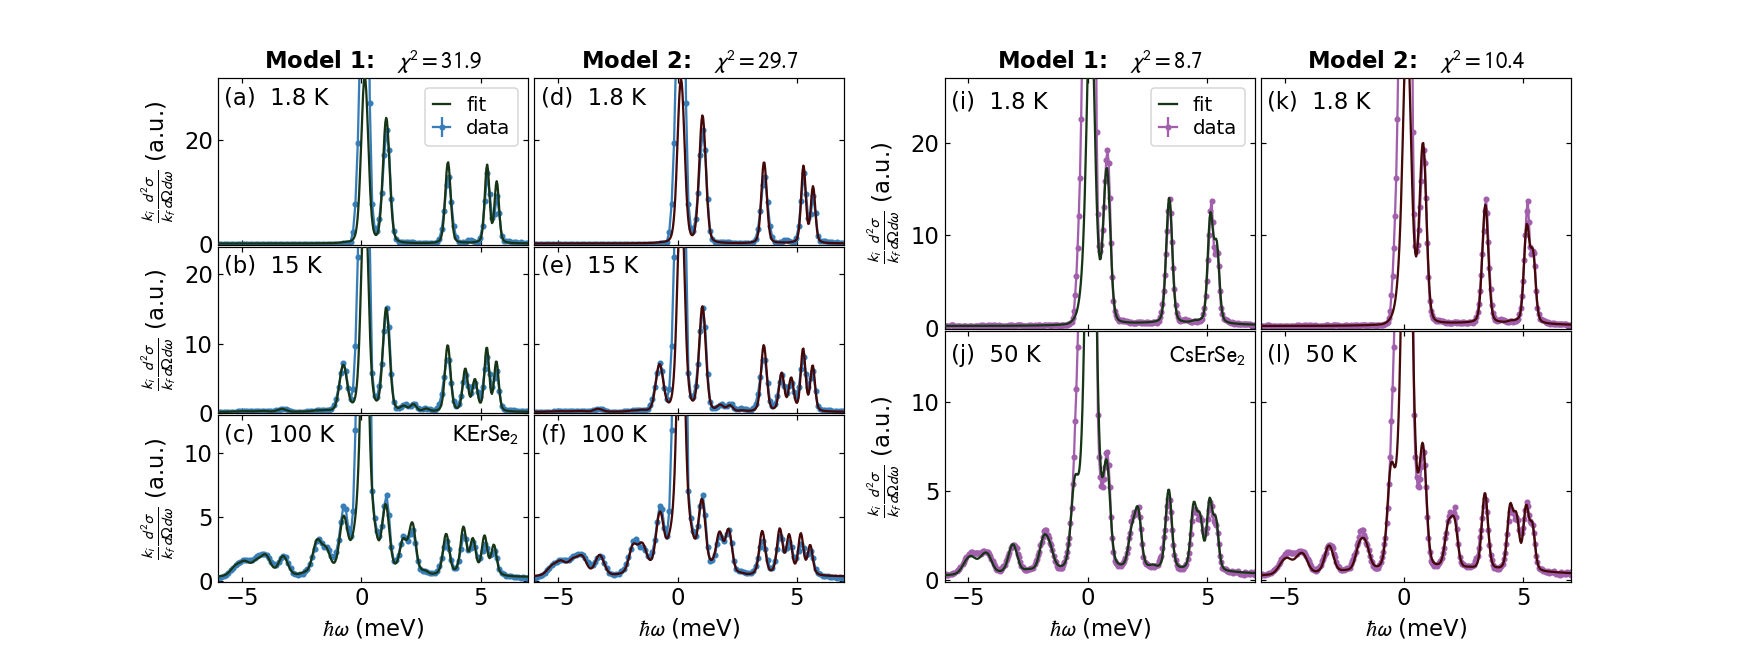

In [13]:
# model1color=pf.cpal1[2]
# model2color=pf.cpal1[0]
model1color= pf.adjustlightness(pf.cpal1[2], 0.3)#'k'
model2color= pf.adjustlightness(pf.cpal1[0], 0.3)
KEScolor = pf.cpal1[1] # pf.adjustlightness(pf.cpal1[1], 0.5)
CEScolor = pf.adjustlightness(pf.cpal1[3], 0.1, False)
# dataprops = {'ls':'-','marker':'o', 'ms':4, 'mew':1,'color':'k', 'label':'data'}
KESdataprops = {'ls':'-','marker':'.','color':KEScolor, 'label':'data'}
CESdataprops = {'ls':'-','marker':'.','color':CEScolor, 'label':'data'}

xxx = np.linspace(-10,30,1200)

sf = 1e3

f = plt.figure(figsize=(16, 6))
outer = gridspec.GridSpec(1, 2, wspace = 0.16) 
gs01 = gridspec.GridSpecFromSubplotSpec(3, 2, subplot_spec = outer[0], wspace=0.02, hspace=0.01)
gs11 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec = outer[1], wspace=0.02, hspace=0.01)

ax1 = np.array([f.add_subplot(gs01[i,j]) for i in range(3) for j in range(2)]).reshape(3,2)
ax3 = np.array([f.add_subplot(gs11[i,j]) for i in range(2) for j in range(2)]).reshape(2,2)


#############################################################################
#############################################################################
############################################################################# KES

for i,data in enumerate(KESalldata):
    for j in range(2):
        ax1[i,j].errorbar(data[0], data[1], data[2], **KESdataprops)
        #ax1[i,j].set_ylim(-0.1,32)
        ax1[i,j].set_xlim(-6,7)
        ax1[-1,j].set_xlabel('$\\hbar \\omega$ (meV)')
    ax1[i,0].set_ylabel('$\\frac{k_i}{k_f} \\frac{d^2 \sigma}{d \\Omega d \\omega}$ (a.u.)')

    ax1[i,0].plot(xxx, sf*(KESFitCoefRes1a['pref']*KESErCoefFit1a.normalizedNeutronSpectrum(
                  Earray=xxx*(1+KESdatatemps[i]*KESFitCoefRes1a['thermexp']) - KESFitCoefRes1a['xoff'], 
                    Temp=KESdatatemps[i], ResFunc=lambda de: straightline(de,*KESwidth_popt),  
                                    gamma=KESFitCoefRes1a['gammas'][i]) + KESFitCoefRes1a['bkg'][i]),
              zorder=10, label='fit', color=model1color)
    
    ax1[i,1].plot(xxx, sf*(KESFitCoefRes2a['pref']*KESErCoefFit2a.normalizedNeutronSpectrum(
                 Earray=xxx*(1+KESdatatemps[i]*KESFitCoefRes1a['thermexp'])-KESFitCoefRes2a['xoff'], 
                Temp=KESdatatemps[i], ResFunc=lambda de: straightline(de,*KESwidth_popt),  
                                    gamma=KESFitCoefRes2a['gammas'][i]) + KESFitCoefRes2a['bkg'][i]),
               zorder=10, label='fit', color=model2color)
    plt.setp(ax1[i,1].get_yticklabels(), visible=False)
               
#     ax[i,2].plot(xxx, sf*(KESFitCoefRes3a['pref']*KESErCoefFit3a.normalizedNeutronSpectrum(
#                                     Earray=xxx-KESFitCoefRes3a['xoff'], Temp=KESdatatemps[i],
#                                     ResFunc=lambda de: straightline(de,*KESwidth_popt),  
#                                     gamma=KESFitCoefRes3a['gammas'][i]) + 0.0001),
#               zorder=10, color=pf.cpal1[2])
    

    
for i in range(2):
    ax1[0,i].set_title('Model '+str(i+1)+':   $\chi^2='+str(np.around(KESFCR[i]['Chisq'],1))+'$',
                     fontsize=15, weight='bold')
    ax1[0,i].set_ylim(-0.1,32)
    ax1[1,i].set_ylim(-0.1,24)
    ax1[2,i].set_ylim(-0.1,13)

    
ax1[0,0].legend(loc=1, fontsize=13, handlelength=0.9, labelspacing=0.2)


    
subplotlabels = 'abcdefghijklmnopqrstuvwx'
for i, axx in enumerate(ax1.T.flatten()):
    axx.text(0.02,0.95, '('+subplotlabels[i]+')  '+str(KESdatatemps[i%3])+' K', transform=axx.transAxes,
              verticalalignment='top', horizontalalignment='left')
    
ax1[-1,0].text(0.97,0.95, '$\\rm KErSe_2$', transform=ax1[-1,0].transAxes,
              verticalalignment='top', horizontalalignment='right')
    

#############################################################################
#############################################################################
############################################################################# CES

for i,data in enumerate(CESalldata):
    for j in range(2):
        ax3[i,j].errorbar(data.cx, data.ci, data.ce,  **CESdataprops)
        #ax3[i,j].set_ylim(-0.1,32)
        ax3[i,j].set_xlim(-6,7)
        ax3[-1,j].set_xlabel('$\\hbar \\omega$ (meV)')
    ax3[i,0].set_ylabel('$\\frac{k_i}{k_f} \\frac{d^2 \sigma}{d \\Omega d \\omega}$ (a.u.)')

    ax3[i,0].plot(xxx, (CESFitCoefRes1b['pref']*CESErCoefFit1.normalizedNeutronSpectrum(
                       Earray=xxx*(1+CESdatatemps[i]*CESFitCoefRes1b['thermexp'])-CESFitCoefRes1b['xoff'], 
                    Temp=CESdatatemps[i], ResFunc=lambda de: straightline(de,*CESwidth_popt),  
                                    gamma=CESFitCoefRes1b['gammas'][i]) + bkg(i, xxx)),
              zorder=10, label='fit', color=model1color)
    
    ax3[i,1].plot(xxx, (CESFitCoefRes2b['pref']*CESErCoefFit2.normalizedNeutronSpectrum(
                  Earray=xxx*(1+CESdatatemps[i]*CESFitCoefRes2b['thermexp'])-CESFitCoefRes2b['xoff'],
                    Temp=CESdatatemps[i], ResFunc=lambda de: straightline(de,*CESwidth_popt),  
                                    gamma=CESFitCoefRes2b['gammas'][i]) + bkg(i, xxx)),
              zorder=10, label='fit', color=model2color)
    
    plt.setp(ax3[i,1].get_yticklabels(), visible=False)
    ax3[0,i].set_ylim(-0.1,27)
    ax3[1,i].set_ylim(-0.1,14)
    
    
for i in range(2):
    ax3[0,i].set_title('Model '+str(i+1)+':   $\chi^2='+str(np.around(CESFCR[i]['Chisq'],1))+'$',
                     fontsize=15, weight='bold')

    
ax3[0,0].legend(loc=1, fontsize=13, handlelength=0.9, labelspacing=0.2)


for i, axx in enumerate(ax3.T.flatten()):
    axx.text(0.02,0.95, '('+subplotlabels[i+8]+')  '+str(CESdatatemps[i%2])+' K', transform=axx.transAxes,
              verticalalignment='top', horizontalalignment='left')
    
ax3[-1,0].text(0.97,0.95, '$\\rm CsErSe_2$', transform=ax3[-1,0].transAxes,
              verticalalignment='top', horizontalalignment='right')
    


plt.tight_layout()
pf.replace_zeros()

# Plot susceptibility and magnetization

first, plot a huge plot with everything. 

Second, plot a single-column plot with magnetization and susceptibility

In [14]:
## Compute susceptibility

## SusceptibilityConversionFactor: Convert emu/Oe/mol to mu_B/T/ion
Na = 6.02214076e23 
SCF = 1/(1.07828221e24/Na)

  #  #  ####   ###
  # #   #     #  
  ##    ###    ##
  # #   #        #
  #  #  ####  ###

# import susceptibility
rawKESMTdata = np.genfromtxt('KErSe2_bulkdata/MT.dat', 
                       delimiter='\t', unpack=True, skip_header=2, skip_footer=1263-542)
## Take some averages because it is TOO many data points
KESMTdata = []
for i in range(len(rawKESMTdata)):
    KESMTdata.append(np.nanmean(rawKESMTdata[i].reshape(-1,3), axis=1))

Temp = np.linspace(4,300,200)
KEScalcsuscep1 = KESErCoefFit1a.susceptibility('Er3+', Temp,  1., 0.001)
KEScalcsuscep2 = KESErCoefFit2a.susceptibility('Er3+', Temp,  1., 0.001)
KEScalcsuscep1_AB = -KESErCoefFit1a.susceptibility('Er3+', Temp,  [1,0,0], 0.001)
KEScalcsuscep2_AB = -KESErCoefFit2a.susceptibility('Er3+', Temp,  [1,0,0], 0.001)
KEScalcsuscep1_C  = -KESErCoefFit1a.susceptibility('Er3+', Temp,  [0,0,1], 0.001)
KEScalcsuscep2_C  = -KESErCoefFit2a.susceptibility('Er3+', Temp,  [0,0,1], 0.001)


   ###  ####   ###
  #     #     #  
  #     ###    ##
  #     #        #
   ###  ####  ###
    
# import susceptibility
RawMTdata = np.genfromtxt('CsErSe2_bulkdata/CsErSe2_MTall.dat', 
                       delimiter='\t', unpack=True, skip_header=1)
## Take some averages because it is TOO many data points
CESMTdata = []
for i in range(len(RawMTdata)):
    CESMTdata.append(np.mean(RawMTdata[i].reshape(-1,5), axis=1))

CEScalcsuscep1 = CESErCoefFit1.susceptibility('Er3+', Temp,  1., 0.001)
CEScalcsuscep2 = CESErCoefFit2.susceptibility('Er3+', Temp,  1., 0.001)
CEScalcsuscep1_AB = -CESErCoefFit1.susceptibility('Er3+', Temp,  [1,0,0], 0.001)
CEScalcsuscep2_AB = -CESErCoefFit2.susceptibility('Er3+', Temp,  [1,0,0], 0.001)
CEScalcsuscep1_C  = -CESErCoefFit1.susceptibility('Er3+', Temp,  [0,0,1], 0.001)
CEScalcsuscep2_C  = -CESErCoefFit2.susceptibility('Er3+', Temp,  [0,0,1], 0.001)

<IPython.core.display.Javascript object>


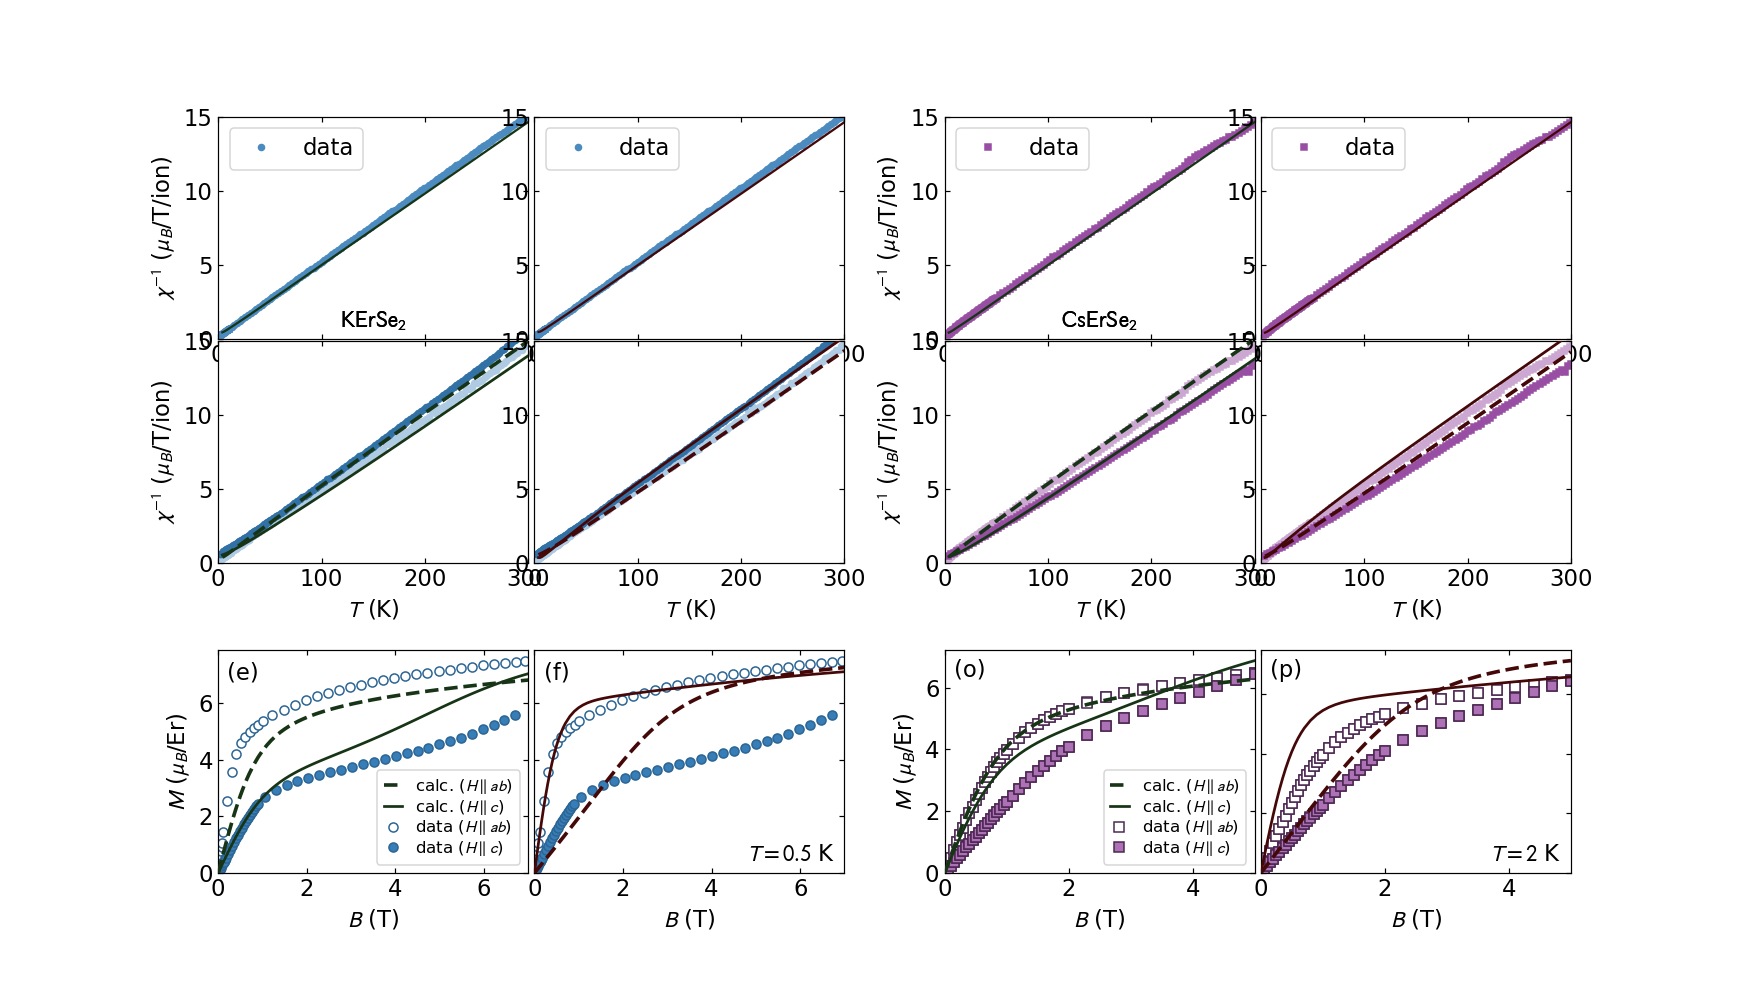

In [15]:
f = plt.figure(figsize=(16, 9))
outer = gridspec.GridSpec(1, 2, wspace = 0.16) 
gs0 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[0], height_ratios = [1, 0.5], hspace = 0.26) 
gs1 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[1], height_ratios = [1, 0.5], hspace = 0.26)

gs01 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec = gs0[0], wspace=0.02, hspace=0.01)
gs02 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = gs0[1], wspace=0.02)
gs11 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec = gs1[0], wspace=0.02, hspace=0.01)
gs12 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = gs1[1], wspace=0.02)

ax1 = np.array([f.add_subplot(gs01[i,j]) for i in range(2) for j in range(2)]).reshape(2,2)
ax2 = np.array([f.add_subplot(gs02[i]) for i in range(2)])

ax3 = np.array([f.add_subplot(gs11[i,j]) for i in range(2) for j in range(2)]).reshape(2,2)
ax4 = np.array([f.add_subplot(gs12[i]) for i in range(2)])


KEScolor= pf.cpal1[1]
CEScolor = pf.cpal1[3]


KESab_data = {'marker':'o', 'ls':'none', 'color':pf.adjustlightness(KEScolor, 0.6, False), 'markersize':4}
KESc_data = {'marker':'o', 'ls':'none',  'color':pf.adjustlightness(KEScolor,0.9), 'markersize':4}
KESpow_data = {'marker':'o', 'ls':'none','color':pf.adjustlightness(KEScolor, 0.1, False), 'markersize':4}

CESab_data = {'marker':'s', 'ls':'none', 'color':pf.adjustlightness(CEScolor, 0.5, False), 'markersize':4}
CESc_data = {'marker':'s', 'ls':'none', 'color':CEScolor, 'markersize':4}
CESpow_data = {'marker':'s', 'ls':'none','color':CEScolor, 'markersize':4}

c_theory = {'zorder':10,  'ls':'-', 'lw':1.8}
ab_theory = {'zorder':10, 'ls':'--', 'lw':2.4}
abc_theory = [ab_theory,ab_theory,c_theory]
#abc_colors_th = [pf.cpalpaired[1], pf.cpalpaired[1], pf.cpalpaired[5]]
thlabels = ['calc. ($H \\parallel ab$)', 'calc. ($H \\parallel ab$)', 'calc. ($H \\parallel c$)']

#########################################################################################
############   Plot Susceptibility    ###########
#########################################################################################

KESpowmodels = [KEScalcsuscep1, KEScalcsuscep2]
KES_ab_models =[KEScalcsuscep1_AB, KEScalcsuscep2_AB]
KES_c_models = [KEScalcsuscep1_C, KEScalcsuscep2_C]
CESpowmodels = [CEScalcsuscep1,    CEScalcsuscep2]
CES_ab_models =[CEScalcsuscep1_AB, CEScalcsuscep2_AB]
CES_c_models = [CEScalcsuscep1_C,  CEScalcsuscep2_C]
modelcolors = [model1color, model2color]
for i in range(2):
    # Plot powder data
    ax1[0,i].plot(KESMTdata[0], KESMTdata[2]*SCF, label='data', **KESpow_data)
    ax1[0,i].plot(Temp,1/-KESpowmodels[i], color=modelcolors[i])
    # Plot single crystal data
    ax1[1,i].plot(KESMTdata[3], KESMTdata[5]*SCF, label='ab', **KESab_data)
    ax1[1,i].plot(KESMTdata[6], KESMTdata[8]*SCF, label='c',  **KESc_data)
    ax1[1,i].plot(Temp,1/KES_ab_models[i][:,0], color=modelcolors[i], **ab_theory)
    ax1[1,i].plot(Temp,1/KES_c_models[i][:,2], color=modelcolors[i], **c_theory)
    
    ax1[1,i].set_xlabel('$T$ (K)')
    ax1[i,0].set_ylabel('$\chi^{-1}$ ($\mu_B$/T/ion)')
    ax1[0,i].legend()
    ax1[0,0].text(0.5,0.03,'$\\rm{KErSe_2}$',
            horizontalalignment='center',verticalalignment='bottom', transform=ax1[0,0].transAxes)
    for j in range(2):
        ax1[j,i].set_xlim(0,300)
        ax1[j,i].set_ylim(0,15)

        
    # Plot powder data
    ax3[0,i].plot(CESMTdata[0], 1/CESMTdata[1]*SCF, label='data', **CESpow_data)
    ax3[0,i].plot(Temp,1/-CESpowmodels[i], color=modelcolors[i])
    # Plot single crystal data
    ax3[1,i].plot(CESMTdata[0], 1/CESMTdata[1]*SCF, label='ab', **CESab_data)
    ax3[1,i].plot(CESMTdata[12], 1/CESMTdata[13]*SCF, label='c',  **CESc_data)
    ax3[1,i].plot(Temp,1/CES_ab_models[i][:,0], color=modelcolors[i], **ab_theory)
    ax3[1,i].plot(Temp,1/CES_c_models[i][:,2], color=modelcolors[i], **c_theory)
    
    ax3[1,i].set_xlabel('$T$ (K)')
    ax3[i,0].set_ylabel('$\chi^{-1}$ ($\mu_B$/T/ion)')
    ax3[0,i].legend()
    ax3[0,0].text(0.5,0.03,'$\\rm{CsErSe_2}$',
            horizontalalignment='center',verticalalignment='bottom', transform=ax3[0,0].transAxes)
    for j in range(2):
        ax3[j,i].set_xlim(0,300)
        ax3[j,i].set_ylim(0,15)






#########################################################################################
############   Plot magnetization   ###########
#########################################################################################

KESab_dataM = {'marker':'o', 'ls':'none', 'mfc':'w', 'mec':  pf.adjustlightness(KEScolor, 0.8)}
KESc_dataM = {'marker':'o', 'ls':'none', 'color':KEScolor, 'mec':pf.adjustlightness(KEScolor, 0.8)}

CESab_dataM = {'marker':'s', 'ls':'none', 'mfc':'w', 'mec':pf.adjustlightness(CEScolor, 0.5)}
CESc_dataM = {'marker':'s', 'ls':'none', 'color':pf.adjustlightness(CEScolor,0.2,False), 
          'mec':pf.adjustlightness(CEScolor, 0.5)}


#########################################################################################

for i in [0,2]:
    ax2[0].plot(KESfieldstrengths, -KESmagnetization1[:,i,i], label=thlabels[i],
                color=model1color, **abc_theory[i])
    ax2[1].plot(KESfieldstrengths, -KESmagnetization2[:,i,i],color=model2color, **abc_theory[i])

ax2[0].set_ylabel('$M$ ($\mu_B$/Er)')


# ax[0].text(2.1,5.0,'$H \\parallel ab$', color=abc_colors[0])
# ax[0].text(3.7,3.2,'$H \\parallel c$', color=abc_colors[2])

ax2[-1].text(0.97,0.03,'$T=0.5$ K', transform=ax2[-1].transAxes, 
            verticalalignment='bottom',horizontalalignment='right')

for i,axx in enumerate(ax2):
    axx.plot(KESMHdata[2]/1e4,KESMHdata[3],  label='data ($H \\parallel ab$)', **KESab_dataM)
    axx.plot(KESMHdata[22]/1e4,KESMHdata[23], label='data ($H \\parallel c$)', **KESc_dataM)
    axx.set_xlabel('$B$ (T)')
    axx.text(0.03,0.95, '('+subplotlabels[i+len(ax1.flatten())]+')  ', transform=axx.transAxes,
              verticalalignment='top', horizontalalignment='left')
    axx.set_xlim(0,7)
    axx.set_ylim(0,)
    
plt.setp(ax2[1].get_yticklabels(), visible=False)


################################################################

#########################################################################################

for i in [0,2]:
    ax4[0].plot(CESfieldstrengths, -CESmagnetization1[:,i,i], label=thlabels[i], 
                color=model1color,**abc_theory[i])
    ax4[1].plot(CESfieldstrengths, -CESmagnetization2[:,i,i], color=model2color,**abc_theory[i])

ax4[0].set_ylabel('$M$ ($\mu_B$/Er)')


# ax[0].text(2.1,5.0,'$H \\parallel ab$', color=abc_colors[0])
# ax[0].text(3.7,3.2,'$H \\parallel c$', color=abc_colors[2])

ax4[-1].text(0.97,0.03,'$T=2$ K', transform=ax4[-1].transAxes, 
            verticalalignment='bottom',horizontalalignment='right')

for i,axx in enumerate(ax4):
    axx.plot(CESMHdata[0]/1e4,CESMHdata[1],label='data ($H \\parallel ab$)', **CESab_dataM)
    axx.plot(CESMHdata[6]/1e4,CESMHdata[7],label='data ($H \\parallel c$)', **CESc_dataM)
    axx.set_xlabel('$B$ (T)')
    axx.text(0.03,0.96, '('+subplotlabels[i+8+6]+')', transform=axx.transAxes,
              verticalalignment='top', horizontalalignment='left')
    axx.set_xlim(0,5)
    axx.set_ylim(0,)

plt.setp(ax4[1].get_yticklabels(), visible=False)
ax4[0].legend(handlelength=1.1, fontsize=11, labelspacing=0.1)
ax2[0].legend(handlelength=1.1, fontsize=11, labelspacing=0.1)

According to Duminda, the single-crystal susceptibility has some variation each time the single crystal is reoriented. Subsequent measurements showed that the slight differences in the high-temperature susceptibility were not reproducible. Furthermore, they are heavily influenced be changing demagnetization factors as the sample is reoriented. Thus, we will not include single-crystal susceptibility in this analysis.

In [16]:
## Import processed magnetization at 2 K

KES_MT_2 = np.genfromtxt('KErSe2_bulkdata/'+\
           'RE__CsErSe2_heat_capacity_and_magnetization_results/KES_Magnetization.txt')

<IPython.core.display.Javascript object>


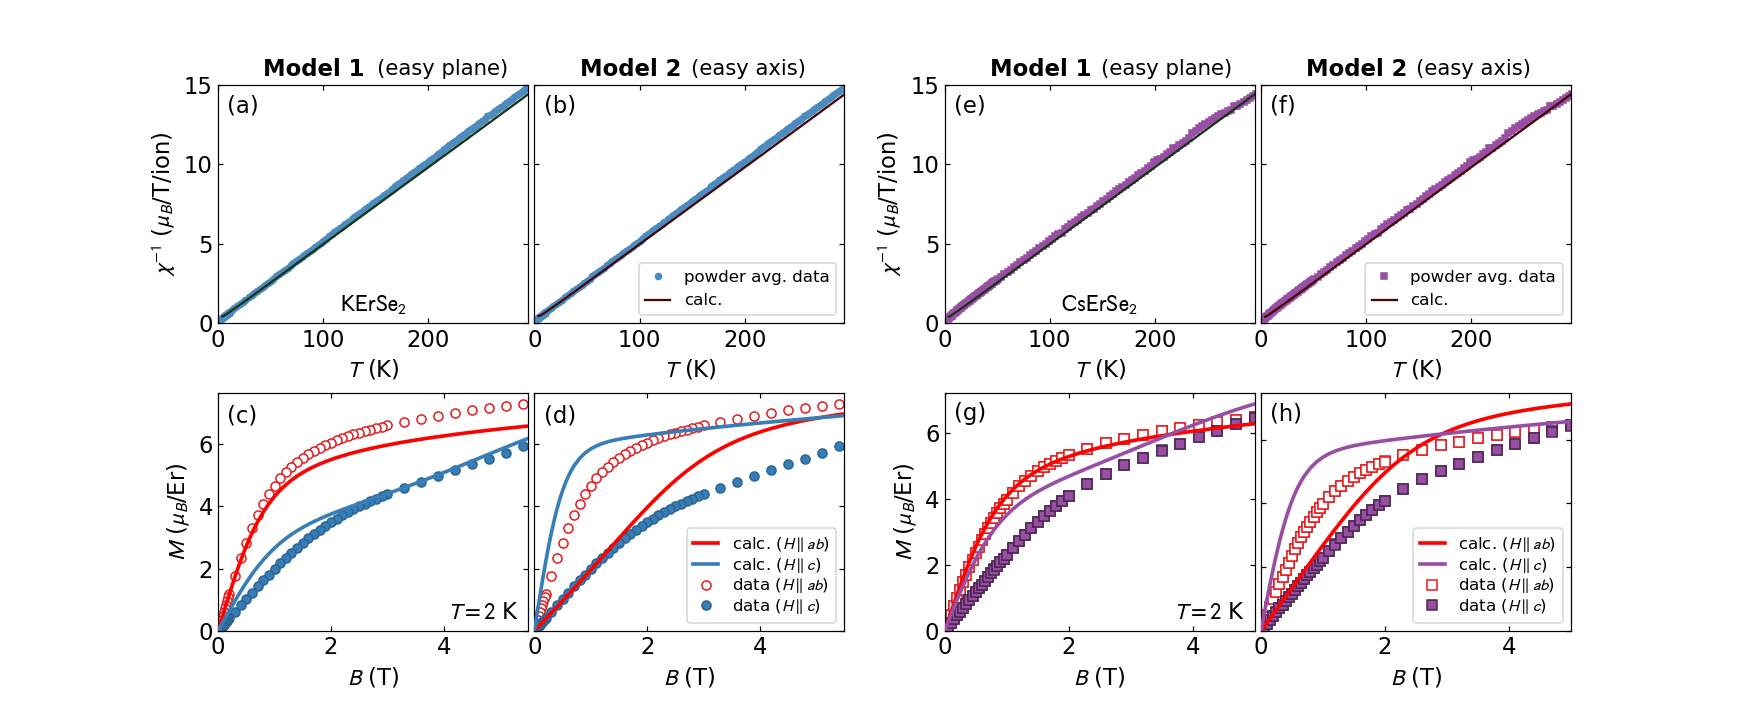

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.8109999999999999, 0.894, '(easy axis)')

In [17]:
f = plt.figure(figsize=(16, 6.5))
outer = gridspec.GridSpec(1, 2, wspace = 0.16) 
gs0 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[0],  hspace = 0.29) 
gs1 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[1],  hspace = 0.29)

gs01 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = gs0[0], wspace=0.02, hspace=0.01)
gs02 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = gs0[1], wspace=0.02)
gs11 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = gs1[0], wspace=0.02, hspace=0.01)
gs12 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = gs1[1], wspace=0.02)

ax1 = np.array([f.add_subplot(gs01[i]) for i in range(2)])
ax2 = np.array([f.add_subplot(gs02[i]) for i in range(2)])

ax3 = np.array([f.add_subplot(gs11[i]) for i in range(2)])
ax4 = np.array([f.add_subplot(gs12[i]) for i in range(2)])


KEScolor= pf.cpal1[1]
CEScolor = pf.cpal1[3]


KESab_data = {'marker':'o', 'ls':'none', 'color':pf.adjustlightness(KEScolor, 0.6, False), 'markersize':4}
KESc_data = {'marker':'o', 'ls':'none',  'color':pf.adjustlightness(KEScolor,0.9), 'markersize':4}
KESpow_data = {'marker':'o', 'ls':'none','color':pf.adjustlightness(KEScolor, 0.1, False), 'markersize':4}

CESab_data = {'marker':'s', 'ls':'none', 'color':pf.adjustlightness(CEScolor, 0.5, False), 'markersize':4}
CESc_data = {'marker':'s', 'ls':'none', 'color':CEScolor, 'markersize':4}
CESpow_data = {'marker':'s', 'ls':'none','color':CEScolor, 'markersize':4}

c_theory = {'zorder':10,  'ls':'-', 'lw':1.8}
ab_theory = {'zorder':10, 'ls':'--', 'lw':2.4}
abc_theory = [ab_theory,ab_theory,c_theory]
#abc_colors_th = [pf.cpalpaired[1], pf.cpalpaired[1], pf.cpalpaired[5]]
thlabels = ['calc. ($H \\parallel ab$)', 'calc. ($H \\parallel ab$)', 'calc. ($H \\parallel c$)']

#########################################################################################
############   Plot Susceptibility    ###########
#########################################################################################

KESpowmodels = [KEScalcsuscep1, KEScalcsuscep2]
KES_ab_models =[KEScalcsuscep1_AB, KEScalcsuscep2_AB]
KES_c_models = [KEScalcsuscep1_C, KEScalcsuscep2_C]
CESpowmodels = [CEScalcsuscep1,    CEScalcsuscep2]
CES_ab_models =[CEScalcsuscep1_AB, CEScalcsuscep2_AB]
CES_c_models = [CEScalcsuscep1_C,  CEScalcsuscep2_C]
modelcolors = [model1color, model2color]
axistype = ['(easy plane)', '(easy axis)']
for i in range(2):
    # Plot powder data
    ax1[i].plot(KESMTdata[0], KESMTdata[2]*SCF, label='powder avg. data', **KESpow_data)
    ax1[i].plot(Temp,1/-KESpowmodels[i], color=modelcolors[i], label='calc.')
    
    ax1[i].set_xlabel('$T$ (K)')
    ax1[0].set_ylabel('$\chi^{-1}$ ($\mu_B$/T/ion)')
    ax1[1].legend(loc=4, handlelength=1.5, fontsize=11)

    ax1[i].set_xlim(0,295)
    ax1[i].set_ylim(0,15)

        
    # Plot powder data
    ax3[i].plot(CESMTdata[0], 1/CESMTdata[1]*SCF, label='powder avg. data', **CESpow_data)
    ax3[i].plot(Temp,1/-CESpowmodels[i], color=modelcolors[i], label='calc.')
    
    ax3[i].set_xlabel('$T$ (K)')
    ax3[0].set_ylabel('$\chi^{-1}$ ($\mu_B$/T/ion)')
    ax3[1].legend(loc=4, handlelength=1.5, fontsize=11)

    
    ax3[i].set_xlim(0,295)
    ax3[i].set_ylim(0,15)

    ax1[i].set_title('Model '+str(i+1)+' '*15, fontsize=15, weight='bold')
    ax3[i].set_title('Model '+str(i+1)+' '*15, fontsize=15, weight='bold')
#     ax1[i].set_title(' '*9+axistype[i], fontsize=15)
#     ax3[i].set_title(' '*9+axistype[i], fontsize=15)

plt.setp(ax1[1].get_yticklabels(), visible=False)
plt.setp(ax3[1].get_yticklabels(), visible=False)

ax3[0].text(0.5,0.03,'$\\rm{CsErSe_2}$',
        horizontalalignment='center',verticalalignment='bottom', transform=ax3[0].transAxes)
ax1[0].text(0.5,0.03,'$\\rm{KErSe_2}$',
        horizontalalignment='center',verticalalignment='bottom', transform=ax1[0].transAxes)
    
#########################################################################################
############   Plot magnetization   ###########
#########################################################################################

KESab_dataM = {'marker':'o', 'ls':'none', 'mfc':'w', 
               'mec':  pf.cpal1[0]}
KESc_dataM = {'marker':'o', 'ls':'none', 'color':KEScolor, 'mec':pf.adjustlightness(KEScolor, 0.8)}

CESab_dataM = {'marker':'s', 'ls':'none', 'mfc':'w', 
               'mec':  pf.cpal1[0]}
CESc_dataM = {'marker':'s', 'ls':'none', 'color':pf.adjustlightness(CEScolor,0.0,False), 
          'mec':pf.adjustlightness(CEScolor, 0.5)}

# c_theory = {'zorder':10,  'ls':'-', 'lw':1.8}
# ab_theory = {'zorder':10, 'ls':'--', 'lw':2.4}
c_theory = {'zorder':10,  'ls':'-', 'lw':2.4}
ab_theory = {'zorder':10, 'ls':'-', 'lw':2.4}
abc_theory = [ab_theory,ab_theory,c_theory]
abthcol = 'r' #pf.adjustlightness(pf.cpal1[0], 0.85)
MthcolorsK = [abthcol, abthcol, KEScolor]
MthcolorsC = [abthcol, abthcol, CEScolor]

#########################################################################################

for i in [0,2]:
    ax2[0].plot(KESfieldstrengths, -KESmagnetization1[:,i,i], label=thlabels[i],
                color=MthcolorsK[i], **abc_theory[i])
    ax2[1].plot(KESfieldstrengths, -KESmagnetization2[:,i,i],  label=thlabels[i],
                color=MthcolorsK[i], **abc_theory[i])

ax2[0].set_ylabel('$M$ ($\mu_B$/Er)')


# ax[0].text(2.1,5.0,'$H \\parallel ab$', color=abc_colors[0])
# ax[0].text(3.7,3.2,'$H \\parallel c$', color=abc_colors[2])

ax2[0].text(0.97,0.03,'$T=2$ K', transform=ax2[0].transAxes, 
            verticalalignment='bottom',horizontalalignment='right')

for i,axx in enumerate(ax2):
    # 0.5 K data
#     axx.plot(KESMHdata[2]/1e4,KESMHdata[3],  label='data ($H \\parallel ab$)', **KESab_dataM)
#     axx.plot(KESMHdata[22]/1e4,KESMHdata[23], label='data ($H \\parallel c$)', **KESc_dataM)
    axx.plot(KES_MT_2[0], KES_MT_2[1],  label='data ($H \\parallel ab$)', **KESab_dataM)
    axx.plot(KES_MT_2[2], KES_MT_2[3], label='data ($H \\parallel c$)', **KESc_dataM)
    
    axx.set_xlabel('$B$ (T)')
    axx.text(0.03,0.95, '('+subplotlabels[i+len(ax1.flatten())]+')  ', transform=axx.transAxes,
              verticalalignment='top', horizontalalignment='left')
#     axx.set_xlim(0,7)
    axx.set_xlim(0,5.5)
    axx.set_ylim(0,)
    
plt.setp(ax2[1].get_yticklabels(), visible=False)


################################################################

#########################################################################################

for i in [0,2]:
    ax4[0].plot(CESfieldstrengths, -CESmagnetization1[:,i,i], label=thlabels[i], 
                color=MthcolorsC[i],**abc_theory[i])
    ax4[1].plot(CESfieldstrengths, -CESmagnetization2[:,i,i], label=thlabels[i], 
                color=MthcolorsC[i],**abc_theory[i])

ax4[0].set_ylabel('$M$ ($\mu_B$/Er)')


# ax[0].text(2.1,5.0,'$H \\parallel ab$', color=abc_colors[0])
# ax[0].text(3.7,3.2,'$H \\parallel c$', color=abc_colors[2])

ax4[0].text(0.97,0.03,'$T=2$ K', transform=ax4[0].transAxes, 
            verticalalignment='bottom',horizontalalignment='right')

for i,axx in enumerate(ax4):
    axx.plot(CESMHdata[0]/1e4,CESMHdata[1],label='data ($H \\parallel ab$)', **CESab_dataM)
    axx.plot(CESMHdata[6]/1e4,CESMHdata[7],label='data ($H \\parallel c$)', **CESc_dataM)
    axx.set_xlabel('$B$ (T)')
    axx.text(0.03,0.96, '('+subplotlabels[i+6]+')', transform=axx.transAxes,
              verticalalignment='top', horizontalalignment='left')
    axx.set_xlim(0,5)
    axx.set_ylim(0,)
    
for i in range(2):
    ax1[i].text(0.03,0.96, '('+subplotlabels[i]+')', transform=ax1[i].transAxes,
              verticalalignment='top', horizontalalignment='left')
    ax3[i].text(0.03,0.96, '('+subplotlabels[i+4]+')', transform=ax3[i].transAxes,
              verticalalignment='top', horizontalalignment='left')

plt.setp(ax4[1].get_yticklabels(), visible=False)
ax4[1].legend(handlelength=1.5, fontsize=11, labelspacing=0.1)
ax2[1].legend(handlelength=1.5, fontsize=11, labelspacing=0.1)

yyyy = 0.894
plt.gcf().text(0.216, yyyy, axistype[0], fontsize=14)
plt.gcf().text(0.396, yyyy, axistype[1], fontsize=14)
plt.gcf().text(0.216+0.415, yyyy, axistype[0], fontsize=14)
plt.gcf().text(0.396+0.415, yyyy, axistype[1], fontsize=14)

# Now what about a magnetic field?

We want to calculate the neutron spectrum of CrErSe2 in various magnetic fields and see what it looks like.
The trouble is, we're looking at a powder, so we must average over all field directions.

In [18]:
fielddata = [DATA[cn] for cn in ['CES_2K_9meV', 'CES_2K_9meV_1T', 'CES_2K_9meV_2T', 
                                 'CES_2K_9meV_3T','CES_2K_9meV_5T']]
fieldtemp = 1.8
fields = [0,1,2,3,5]

In [19]:
def _dLdx(x, a, x0, gamma):
    return -a*16*gamma*(x - x0)/(np.pi*(4*(x-x0)**2 + gamma**2)**2)

def zeemansplitting(obj, Field):
     # A) Define magnetic Hamiltonian
    muB = 5.7883818012e-2  # meV/T
    #mu0 = np.pi*4e-7       # T*m/A
    JdotB = muB*(Field[0]*cef.Operator.Jx(obj.J) + Field[1]*cef.Operator.Jy(obj.J) +\
                 Field[2]*cef.Operator.Jz(obj.J))

    # B) Diagonalize full Hamiltonian
    return JdotB.O


def simulateNS(obj, energies, FitRes, field, numpts=2e4):
    oldH = np.sum([a*b for a,b in zip(obj.O, obj.B)], axis=0)
    # March through locations on a sphere
    signal = np.zeros_like(energies)
    for i in range(numpts):
        x1, x2 = np.random.uniform(-1,1,2)
        if x1**2 + x2**2 >= 1:
            continue
        Bffield = np.array([2*x1*np.sqrt(1-x1**2 - x2**2),
                          2*x2*np.sqrt(1-x1**2 - x2**2),
                          1-2*(x1**2 + x2**2)])*field
        newH = zeemansplitting(obj, Bffield)
        obj.diagonalize(oldH + newH)
        
        signal +=  FitRes['pref']*obj.normalizedNeutronSpectrum(
                                    Earray=energies-FitRes['xoff'], Temp=fieldtemp,
                                    ResFunc=lambda de: straightline(de,*CESwidth_popt),  
                                    gamma=FitRes['gammas'][0])
    return signal/numpts

SimNS_1 = []
SimNS_2 = []

hbaromega = np.linspace(0, fielddata[1].cx[-1], 400)
for i, B in enumerate(fields):
    print(B)
    SimNS_1.append(simulateNS(CESErCoefFit1, hbaromega, CESFitCoefRes1b, B, 500))
    SimNS_2.append(simulateNS(CESErCoefFit2, hbaromega, CESFitCoefRes2b, B, 500))

0
1
2
3
5


<IPython.core.display.Javascript object>


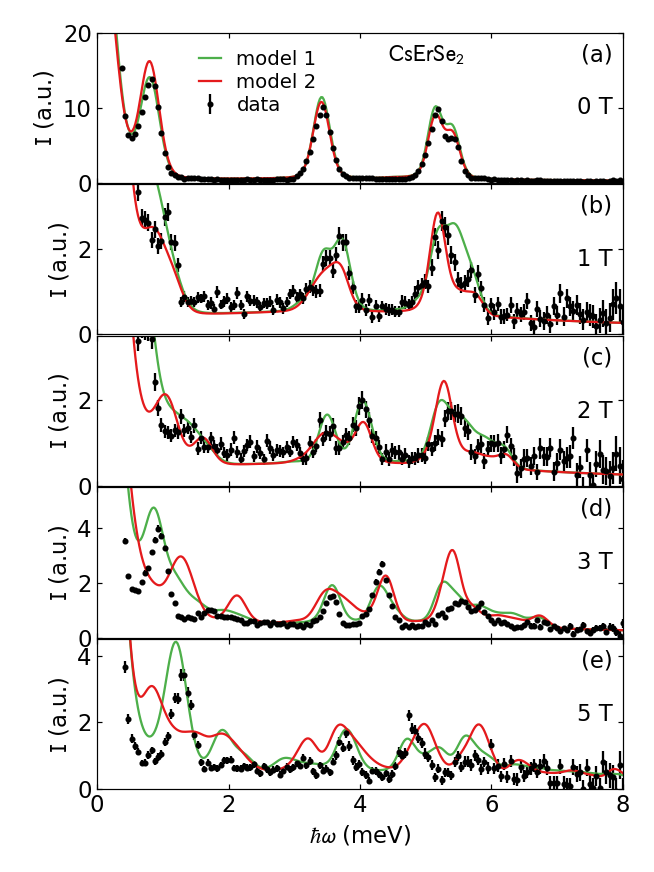

In [20]:
f, ax = plt.subplots(5,1, figsize=(6,8), sharex=True)
scalef = [0.72,2.8,3.2,1,2]
scalef2 = [1,0.45,0.5,1,1]

totalchisq = [0,0]

subplotlabels = 'abcdefghijklmnop'
for i,data in enumerate(fielddata):
    ax[i].errorbar(data.cx, data.ci*scalef[i], data.ce*scalef[i], marker='.', label='data', 
                   color='k', ls='none')
    ax[i].plot(hbaromega, SimNS_1[i]+ bkg(0, hbaromega), label='model 1', color=pf.cpal1[2])
    ax[i].plot(hbaromega, SimNS_2[i]*scalef2[i]+ bkg(0, hbaromega), label='model 2', color=pf.cpal1[0])
    ax[i].text(0.98,0.93,'('+subplotlabels[i]+')\n\n'+ str(fields[i])+' T', transform=ax[i].transAxes,
              horizontalalignment='right',verticalalignment='top')
    ax[i].set_ylabel('$\\rm I$ (a.u.)')
    
    # calculate chi2
#     totalchisq[0] += np.sum((data.ci*scalef[i] - (SimNS_1[i]+ bkg(0, data.cx)) )**2/(data.ce*scalef[i])**2)
#     totalchisq[1] += np.sum((data.ci*scalef[i] - (SimNS_2[i]+ bkg(0, data.cx)) )**2/(data.ce*scalef[i])**2)
    
ax[0].set_ylim(0,20)
ax[0].set_xlim(0,8)
ax[1].set_ylim(0,3.5)
ax[2].set_ylim(0,3.5)
ax[3].set_ylim(0,5.5)
ax[4].set_ylim(0,4.5)

ax[0].legend(loc=2, bbox_to_anchor=(0.16,1), fontsize=13, handlelength=1.1, frameon=False, labelspacing=0.2)
ax[-1].set_xlabel('$\\hbar \\omega$ (meV)')
ax[0].text(0.7,0.93, '$\\rm CsErSe_2$', transform=ax[0].transAxes,
              verticalalignment='top', horizontalalignment='right')

plt.tight_layout()
f.subplots_adjust(hspace=0.01)